In [ ]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
!pip install pyfolio
import pyfolio as pf
import scipy.optimize as sco

In [18]:
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

In [22]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')
N_DAYS=len(prices_df)

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


In [23]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [25]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate): 
    portf_returns = np.sum(avg_rtns * w) 
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility 
    return -portf_sharpe_ratio 
def port_vol(w, avg_rtns, cov_mat, rf_rate):
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w))) 
    return portf_volatility

In [31]:
n_assets = len(avg_returns) 
RF_RATE = 0 

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x)-1})
bounds = tuple((0,1) for asset in range(n_assets)) 
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args, 
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)
min_vol_portf = sco.minimize(port_vol,
                                x0=initial_guess, 
                                args=args, 
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)

In [35]:
max_sharpe_portf

     fun: -0.7537889937851415
     jac: array([6.83071703e-01, 1.22896913e+00, 7.45058060e-09])
 message: 'Optimization terminated successfully'
    nfev: 8
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1.11022302e-16, 1.11022302e-16, 1.00000000e+00])

In [36]:
max_sharpe_portf.x

array([1.11022302e-16, 1.11022302e-16, 1.00000000e+00])

In [33]:
min_vol_portf

     fun: 0.22490606062561103
     jac: array([0.22489808, 0.22491224, 0.22489548])
 message: 'Optimization terminated successfully'
    nfev: 28
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.27957402, 0.58789849, 0.13252749])

In [ ]:
#과제 4

In [37]:
import scipy
import scipy.linalg

In [38]:
T = 1
N= len(returns_df)
N_SIM=10**3

In [39]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)

    dt = T/N 
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

In [40]:
shares=min_vol_portf.x

In [41]:
mu=np.matmul(avg_returns,shares)
sigma = np.matmul(np.matmul(shares,cov_mat.values),shares.T)

In [45]:
gbm_simulations = simulate_gbm(1, mu, sigma, N_SIM, T, N)

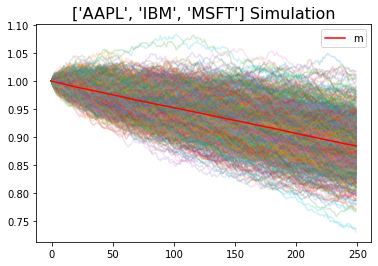

In [48]:
plot_title =(f'{RISKY_ASSETS} Simulation')

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations))

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(gbm_simulations_df.mean(axis=1), 
                  color='red')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1,), ('mean'))

In [49]:
shares=max_sharpe_portf.x

In [50]:
mu=np.matmul(avg_returns,shares)
sigma = np.matmul(np.matmul(shares,cov_mat.values),shares.T)

In [52]:
gbm_simulations = simulate_gbm(1, mu, sigma, N_SIM, T, N)

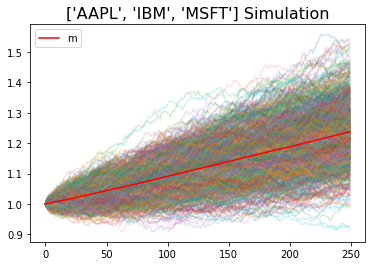

In [53]:
plot_title =(f'{RISKY_ASSETS} Simulation')

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations))

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(gbm_simulations_df.mean(axis=1), 
                  color='red')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1,), ('mean'))